Load packages 

In [79]:
# general packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import time
import os
import numpy as np
%matplotlib inline

# weights and biases for metric training
import wandb 
from torch import optim
import time
import math


# data science
from sklearn.model_selection import train_test_split

# data augmentation
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

# torch stuff
import torch
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.models as models
from torchvision.transforms import Resize, Scale
import torch.nn as nn


In [80]:
!wandb login 76034cebe86f91818db6c4acb3ae71e1e3df7ba1

wandb: Appending key for api.wandb.ai to your netrc file: /Users/simonpassenheim/.netrc


In [81]:
train_df = pd.read_csv("input/train.csv")
# sample submission file can be ignored
sample_df = pd.read_csv("input/sample_submission.csv")

print(len(train_df))
print(len(sample_df))

7095
5506


### Visualization of Image Segmentation on Training Data
code taken from kaggle notebook

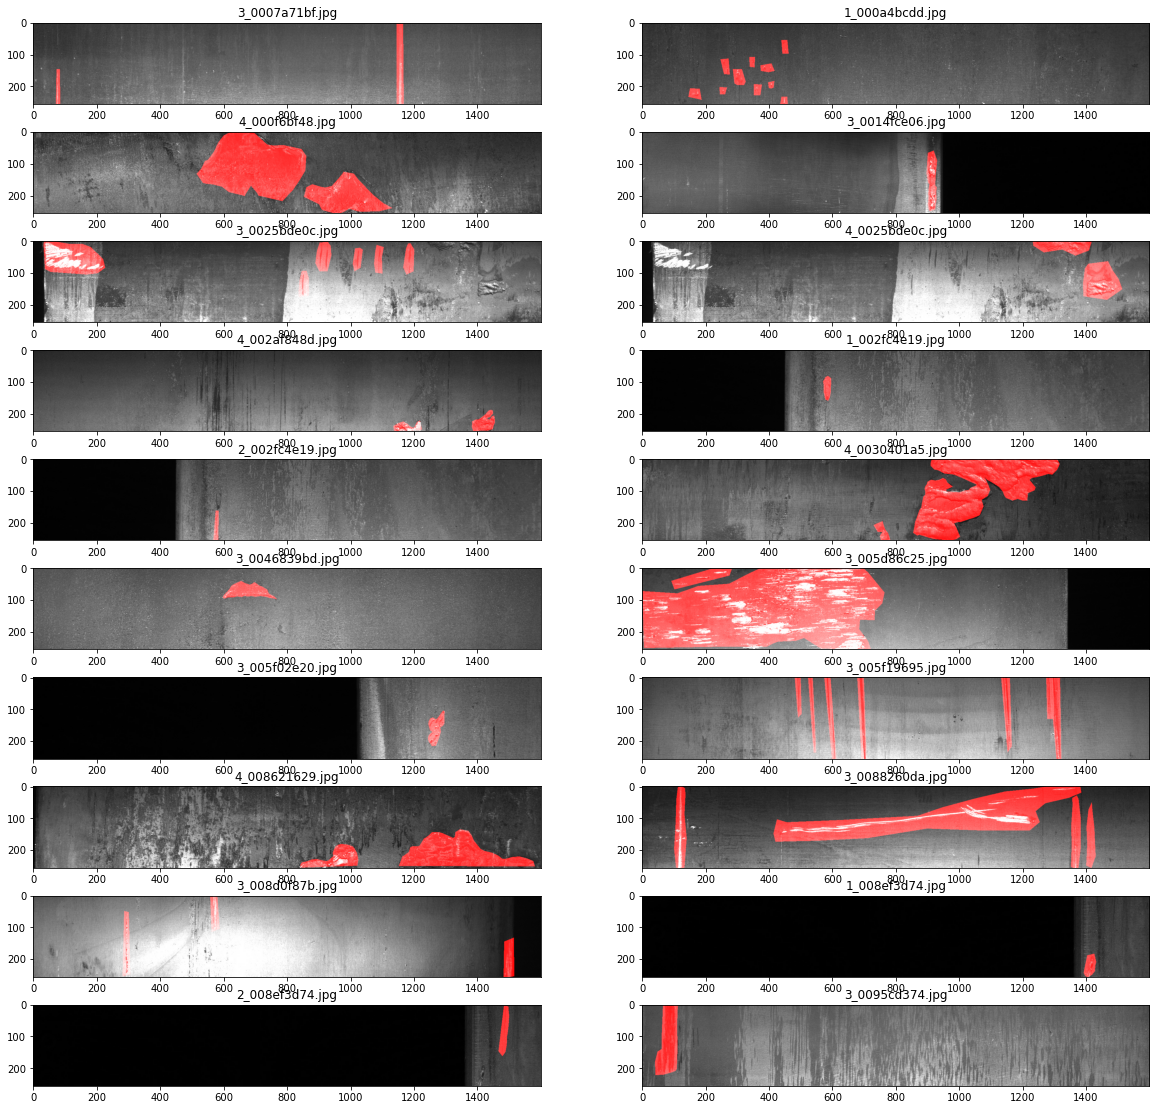

In [82]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50

for i in range(1, 20+1):
    fig.add_subplot(rows, columns, i)

    fn = train_df['ImageId'].iloc[i]
    img = cv2.imread('input/train_images/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask( train_df['EncodedPixels'].iloc[i], img.shape  )
    img[mask==1,0] = 255
    
    plt.gca().set_title(str(train_df['ClassId'].iloc[i]) + "_" + fn)
    plt.imshow(img)
    
plt.show()

### From kaggle competition - with masks which we don't need for the mometn

In [83]:
# def mask2rle(img):
#     '''
#     img: numpy array, 1 -> mask, 0 -> background
#     Returns run length as string formated
#     '''
#     pixels= img.T.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)

# def make_mask(row_id, df):
#     '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
#     fname = df.iloc[row_id].name
#     labels = df.iloc[row_id][:4]
#     masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
#     # 4:class 1～4 (ch:0～3)

#     for idx, label in enumerate(labels.values):
#         if label is not np.nan:
#             label = label.split(" ")
#             positions = map(int, label[0::2])
#             length = map(int, label[1::2])
#             mask = np.zeros(256 * 1600, dtype=np.uint8)
#             for pos, le in zip(positions, length):
#                 mask[pos:(pos + le)] = 1
#             masks[:, :, idx] = mask.reshape(256, 1600, order='F')
#     return fname, masks

# class SteelDataset(Dataset):
#     def __init__(self, df, data_folder, mean, std, phase):
#         self.df = df
#         self.root = data_folder
#         self.mean = mean
#         self.std = std
#         self.phase = phase
#         self.transforms = get_transforms(phase, mean, std)
#         self.fnames = self.df.index.tolist()

#     def __getitem__(self, idx):
        
#         image_id, mask = make_mask(idx, self.df)
#         image_path = os.path.join(self.root, "train_images",  image_id)
#         img = cv2.imread(image_path)
#         augmented = self.transforms(image=img, mask=mask)
#         img = augmented['image']
#         mask = augmented['mask'] 
#         mask = mask[0].permute(2, 0, 1)

#         return img, mask

#     def __len__(self):
#         return len(self.fnames)
    

# def get_transforms(phase, mean, std):
#     list_transforms = []
    
#     if phase == "train":
#         list_transforms.extend(
#             [
#                 HorizontalFlip(p=0.5), # only horizontal flip as of now
#             ]
#         )
        
#     list_transforms.extend(
#         [
#             Normalize(mean=mean, std=std, p=1),
#             ToTensor(),
#         ]
#     )
    
#     list_trfms = Compose(list_transforms)
#     return list_trfms

# def provider(
#     data_folder,
#     df_path,
#     phase,
#     mean=None,
#     std=None,
#     batch_size=8,
#     num_workers=0,
#     ):
    
#     '''Returns dataloader for the model training'''
#     df = pd.read_csv(df_path)
    
#     df['ClassId'] = df['ClassId'].astype(int)

#     df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    
#     df['defects'] = df.count(axis=1)
    
#     train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    
#     df = train_df if phase == "train" else val_df
    
#     image_dataset = SteelDataset(df, data_folder, mean, std, phase)

#     dataloader = DataLoader(
#         image_dataset,
#         batch_size=batch_size,
#         num_workers=num_workers,
#         pin_memory=True,
#         shuffle=True,   
#     )

#     return dataloader

### Data set with class labels

Inspired by https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88

In [84]:
def get_transforms(phase, mean, std):
    list_transforms = []
    
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
        
    list_transforms.extend(
        [   
            Normalize(mean=mean, std=std, p=1),
#             Downscale(scale_min=0.25, scale_max=0.5),   # does not work         
            ToTensor(),
        ]
    )
    
    list_trfms = Compose(list_transforms)
    return list_trfms



# class SteelDataset_v2(Dataset):
#     def __init__(self, df, data_folder, mean, std, phase, rescale_factor = None):
#         self.df = df
#         self.root = data_folder
#         self.mean = mean
#         self.std = std
#         self.phase = phase
#         self.transforms = get_transforms(phase, mean, std)
#         self.fnames = self.df.index.tolist()
#         self.rescale_factor = rescale_factor

#     def __getitem__(self, idx):

#         image_id = self.df.iloc[idx]['ImageId']
#         class_id = self.df.iloc[idx]['ClassId']

#         image_path = os.path.join(self.root, "train_images",  image_id)
#         img = cv2.imread(image_path)

#         augmented = self.transforms(image=img)
#         img = augmented['image']        
        
#         if self.rescale_factor is not None:
#             img = Scale(int(self.rescale_factor * img.shape[1]))(img)
        
#         return img, class_id

#     def __len__(self):
#         return len(self.fnames)

    
class SteelDataset_v2(Dataset):
    def __init__(self, df, data_folder, mean, std, phase, rescale_factor = None):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()
        self.rescale_factor = rescale_factor

    def __getitem__(self, idx):



        image_id = self.df.iloc[idx]['ImageId']
        class_id = self.df.iloc[idx]['ClassId']

        start_time = time.time()
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
#         print(f'Read image time {time.time() - start_time}')

        start_time = time.time()
        augmented = self.transforms(image=img)
        img = augmented['image']        
        
        if self.rescale_factor is not None:
            img = Resize(int(self.rescale_factor * img.shape[1]))(img)
#         print(f'Augment and resize image time {time.time() - start_time}')        
        
        return img, class_id

    def __len__(self):
        return len(self.fnames)    


def get_full_df(df, train_image_folder):
    'Extend class data frame with images of non defects. Encode them with class id 0'

    all_file_names = os.listdir(train_image_folder)

    labeled_file_names = df['ImageId'].to_list()

    complement_file_names = list(set(all_file_names) - set(labeled_file_names))

    missing_files_df = pd.DataFrame(data={'ImageId': complement_file_names, 'ClassId': [0]*len(complement_file_names) })

    full_df =  pd.concat([df,missing_files_df])
    
    return full_df

def provider_v2(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    rescale_factor = None,
    batch_size=8,
    num_workers=0,
    ):
    
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)

    train_image_folder = os.path.join(data_folder, "train_images")
    
    # extend df with ids of images that are not in the original df
    df = get_full_df(df, train_image_folder)
    
    df['ClassId'] = df['ClassId'].astype(int) 
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=69)
    
    if phase == "train":
        df = train_df 
    elif phase == "test":
        df = val_df
    
#     print(f'Class distribution of {phase} set')
#     df['ClassId'].value_counts().plot.bar()
#     plt.show()
    
    image_dataset = SteelDataset_v2(df, data_folder, mean, std, phase, rescale_factor)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False,   
    )

    return dataloader



create train and test data with 1/5 split and 0.25 downscaling of images

In [85]:
BATCH_TRAIN = 256
BATCH_TEST = 256
num_workers = 0
SCALE_FACTOR = 0.25

train_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='train',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_TRAIN,
                num_workers = num_workers)
                        

test_data = provider_v2(data_folder='input/',
                df_path='input/train.csv',
                phase='test',
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                rescale_factor = SCALE_FACTOR,
                batch_size = BATCH_TEST,
                num_workers = num_workers)

In [86]:
start = time.time()
for (el,label) in train_data:
    print(f'Loading time {time.time() - start}')
    print(el.shape)
    break

Loading time 3.5743589401245117
torch.Size([256, 3, 64, 400])


data points in train and test set

In [27]:
print("Number of samples in test and train set")
print(len(train_data)*BATCH_TRAIN)
print(len(test_data)*BATCH_TEST)

Number of samples in test and train set
10397
2816


Calculate weights

In [87]:
df_path = 'input/train.csv'
data_folder='input/'
df = pd.read_csv(df_path)

train_image_folder = os.path.join(data_folder, "train_images")
df = get_full_df(df, train_image_folder)

weights_dict = (1 / df['ClassId'].value_counts()).sort_index().to_dict()
weights_tensor = torch.tensor((1 / df['ClassId'].value_counts()).sort_index()).float()

print(f'Number of classes {len(weights_tensor)}')
print()
print('weight dict', weights_dict)
print('weight tens', weights_tensor)

Number of classes 5

weight dict {0: 0.00016943409013893597, 1: 0.0011148272017837235, 2: 0.004048582995951417, 3: 0.0001941747572815534, 4: 0.0012484394506866417}
weight tens tensor([0.0002, 0.0011, 0.0040, 0.0002, 0.0012])


### load pretrained model
and change fully connected layer output to number of dimensions

In case you want to use an existing model, uncomment the following lines and load it instead

In [88]:
# load pre trained resnet18
resnet18 = models.resnet18(pretrained=True)
model = resnet18

# adjust output layer to number of classes
model.fc = nn.Linear(512, len(weights_tensor))

Helper functions

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score


def accuracy(target, pred):
    """Not a good metric for imbalanced dataset. However, it's a start."""
    return (target == pred.argmax(dim=1)).float().mean()

def conf_matrix(target, pred):
    """
    Args: torch.tensors
    Returns: np matrix
    """
    # apparently have to first detach and then convert to np manually for conf matrix
    pred = pred.detach().numpy()
    return confusion_matrix(target, pred.argmax(axis=1))

def bal_acc(target, pred):
    """
    Average of the recalls per class
    """
    return balanced_accuracy_score(target, pred)

def test_eval(model, MAX_TEST_SAMPLES):

    loss_test = []
    total_pred = torch.tensor([])
    total_pred_probs = torch.tensor([])    
    total_target = torch.tensor([])    
    
    print('\n### EVAL TEST SET ###')

    torch.save(model.state_dict(), 'model/model.h5')
    model.eval()

    MAX_ITER_TEST = math.ceil(MAX_TEST_SAMPLES / BATCH_TEST)

    for idx_test, (el,label) in enumerate(test_data):

        if idx_test > MAX_ITER_TEST - 1: 
            break            

        start = time.time()
        with torch.no_grad():
            pred = model(el)

        loss_test.append(ce_loss(pred, label))

        print(f'Iter {idx_test} / {MAX_ITER_TEST} with loss {(sum(loss_test)/len(loss_test)):.2f} in {(time.time() - start):.2f} s') 
        
        total_pred = torch.cat([total_pred, pred.argmax(dim=1)])
        total_pred_probs = torch.cat([total_pred_probs, pred])        
        total_target = torch.cat([total_target, label])   
    
    bal_acc_test = bal_acc(total_target, total_pred)
    avg_loss_test = sum(loss_test)/len(loss_test)

    print(f'Test loss: {avg_loss_test}')
    
    class_names = ['0', '1', '2', '3', '4']    
    wandb.log({"loss_test": avg_loss_test, 
               "bal_acc_test": bal_acc_test, 
               "conf_mat_test": wandb.plot.confusion_matrix(probs=total_pred_probs.detach().numpy(), y_true=total_target.numpy(), class_names = class_names)})                        
    
    print('### END EVAL TEST ###\n')

### Training 

calculate time duration of single forward and backward pass

In [90]:
img_path = "input/train_images/eabd4acaa.jpg"

start = time.time()
img = cv2.imread(img_path)
print(f'Loading time {time.time() - start}')

Loading time 0.02671217918395996


In [91]:
ce_loss = nn.CrossEntropyLoss(weight = weights_tensor)

start = time.time()
for idx, (x, target) in enumerate(train_data):
    print(f'Loading time {time.time() - start}')
    print()
    print('x.shape',x.shape)
    
    start = time.time()   
    pred = model(x)
    print(f'Forward pass {time.time() - start}')
    
    start = time.time()   
    loss = ce_loss(pred, target)   
    print(f'Loss calculation {time.time() - start}')  
    
    start = time.time()   
    loss.backward()    
    print(f'Backward pass {time.time() - start}')   

    break

Loading time 3.248927116394043

x.shape torch.Size([256, 3, 64, 400])


KeyboardInterrupt: 

In [ ]:
start = time.time()
for idx, (x, label) in enumerate(train_data):
    print(x.shape)
    print(f'Loading time {time.time() - start}')
    if idx == 0:
        break

In [ ]:
start = time.time()
for idx, (x, label) in enumerate(test_data):
    print(x.shape)
    print(f'Loading time {time.time() - start}')
    if idx == 0:
        break

In [92]:

wandb.init(project='defect_identification',
           name='run_7')

wandb: Currently logged in as: simpass (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:


optimizer = optim.Adam(resnet18.parameters())
ce_loss = nn.CrossEntropyLoss(weight = weights_tensor)

EPOCHS = 1
TEST_EVAL_ITER = 10
PLOT_ITER = 5

for epoch in range(EPOCHS):
    
    print(f'### EPOCH {epoch} ###\n')
    
    for idx, (x, label) in enumerate(train_data):

        # train model
        optimizer.zero_grad()
        model.train()
        start = time.time()    
        pred = model(x)
        loss = ce_loss(pred, label)   
        loss.backward()
        optimizer.step()    

        # print stuff
        print(f'Iter {idx} / {len(train_data)} loss {loss.item():.2f} in {(time.time() - start):.2f} s')
        print(f'Plain accuracy: {accuracy(label, pred):.2f}')
        bal_acc_train = bal_acc(label, pred.argmax(dim=1))
        print(f'Aveg. accuracy: {bal_acc_train:.2f}')
        print()
        
        class_names = ['0', '1', '2', '3', '4'] 
        wandb.log({"loss_train": loss, 
                   "bal_acc_train": bal_acc_train,
                   "conf_mat_train": wandb.plot.confusion_matrix(probs=pred.detach().numpy(), y_true=label.numpy(),class_names=class_names)})  

        # Plot training process and conf matrix
        if (idx % PLOT_ITER ) == 0:
            pass
            
        # eval test set
        MAX_TEST_SAMPLES = 1.5e3 # max number of test set samples that we consider 
        if ((idx % TEST_EVAL_ITER) == 0) and (idx != 0):
            test_eval(model, MAX_TEST_SAMPLES)

        # termination condition
        if idx == 100:
              break
